In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("./archive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [4]:
len(captions)

40460

In [5]:
captions[0].split("\t")

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [6]:
descriptions = {}

for x in captions:
    first,second = x.split("\t")
    img_name = first.split(".")[0]

    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

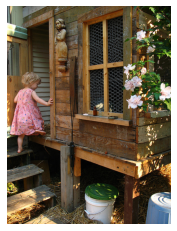

In [8]:
import cv2
import matplotlib.pyplot as plt
IMG_PATH = "./archive/Flickr_Data/Flickr_Data/Images/"

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## cleaning text

In [9]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [10]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [11]:
#clearn all captiopns
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [12]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

## Vocabulary

In [14]:
descriptions = None
with open("descriptions.txt","r") as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [15]:
print(type(descriptions))

<class 'dict'>


In [16]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [17]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print(f"vocab size is {len(vocab)}")

vocab size is 8424


In [18]:
# total words across all the sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print(f"total words {len(total_words)}")

total words 373837


In [19]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [20]:
#sort the dictionary according to the fre count
sorted_freq_count = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#filter
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_count]

In [21]:
print(len(total_words))

1845


## Prepare tain test data

In [22]:
train_file_data = readTextFile("./archive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("./archive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [23]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [24]:
#prepare descriptions for the training data
#tweak - add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [25]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning

In [26]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [27]:
model_new = Model(model.input,model.layers[-2].output)

In [28]:
def preprocessing_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


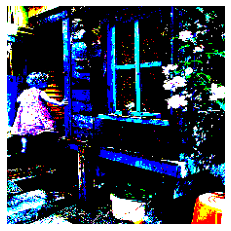

In [29]:
img = preprocessing_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [30]:
def encode_image(img):
    img = preprocessing_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [31]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535947, 0.16782546, 0.32517573, ..., 0.05107125, 0.32821143,
       1.004337  ], dtype=float32)

In [37]:
# start = time()
# encoding_train = {}
# #image_id -->feature_vector extracted from Resnet Image

# for ix,img_id in enumerate(train):
#     img_path = IMG_PATH + "/" + img_id + ".jpg"
#     encoding_test[img_id] = encode_image(img_path)
    
#     if ix%100 == 0:
#         print(f"Encoding in progress: time step",ix)
    
# end_t = time()
# print("Total time taken :",end_t-start)

Encoding in progress: time step 0
Encoding in progress: time step 100
Encoding in progress: time step 200
Encoding in progress: time step 300
Encoding in progress: time step 400
Encoding in progress: time step 500
Encoding in progress: time step 600
Encoding in progress: time step 700
Encoding in progress: time step 800
Encoding in progress: time step 900
Encoding in progress: time step 1000
Encoding in progress: time step 1100
Encoding in progress: time step 1200
Encoding in progress: time step 1300
Encoding in progress: time step 1400
Encoding in progress: time step 1500
Encoding in progress: time step 1600
Encoding in progress: time step 1700
Encoding in progress: time step 1800
Encoding in progress: time step 1900
Encoding in progress: time step 2000
Encoding in progress: time step 2100
Encoding in progress: time step 2200
Encoding in progress: time step 2300
Encoding in progress: time step 2400
Encoding in progress: time step 2500
Encoding in progress: time step 2600
Encoding in p

In [79]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [80]:
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [39]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 70.48525524139404


In [40]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [31]:
#load data 
with open("saved/encoded_train_features.pkl","rb") as f:
    encoding_train = pickle.load(f)

with open("saved/encoded_test_features.pkl","rb") as f:
    encoding_test = pickle.load(f)

## Data preprocessing for captions

In [32]:
len(total_words)

1845

In [33]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [37]:
# word_to_idx["dog"]
# idx_to_word[6]
print(len(word_to_idx),len(idx_to_word))

1845 1845


In [38]:
# adding 2 special words
idx_to_word[1846] = "startseq"
word_to_idx["startseq"] = 1846

idx_to_word[1847] = "endseq"
word_to_idx["endseq"] = 1847

vocab_size = len(word_to_idx) + 1
print("vocab size",vocab_size)

vocab size 1848


In [39]:
with open("saved/word_to_idx.pkl","wb") as f:
    pickle.dump(word_to_idx,f)

with open("saved/idx_to_word.pkl","wb") as f:
    pickle.dump(idx_to_word,f)

In [48]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

print(max_len)

35


## Data loader (generator)

In [85]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n = 0
    
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denotes padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding="post")[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                    if n==batch_size:
                        yield ([np.array(X1),np.array(X2)],np.array(y))
                        X1,X2,y = [],[],[]
                        n = 0

## Word Embeddings

In [53]:
f = open("./../glove.6B.50d.txt",encoding="utf8")

In [51]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype="float")
    embedding_index[word] = word_embedding

In [54]:
f.close()

In [55]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [57]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [58]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

## Model architecture

In [59]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation="relu")(inp_img1)

In [60]:
# captions as input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [61]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation="relu")(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

#combine model
model = Model(inputs=(input_img_features,input_captions),outputs=outputs)

In [62]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [63]:
#embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [64]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

## Training Model

In [65]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [69]:
def train_model():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [86]:
train_model()

   6/2000 [..............................] - ETA: 23s - loss: 3.5482

C:\Users\asus\AppData\Roaming\Python\Python38\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2000/2000 [==============================] - 25s 13ms/step - loss: 2.5636


### def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

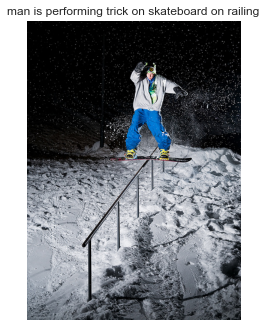

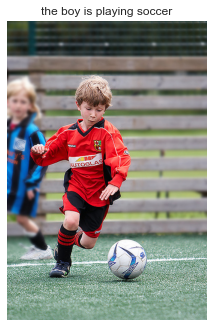

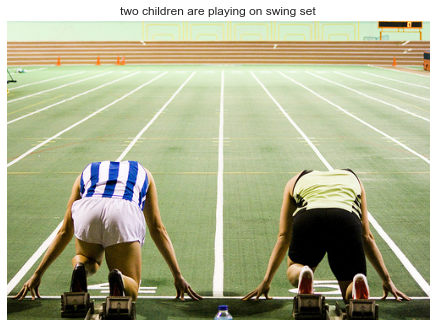

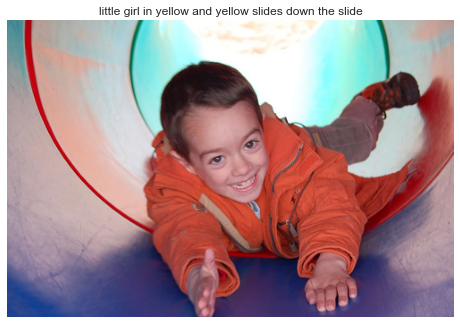

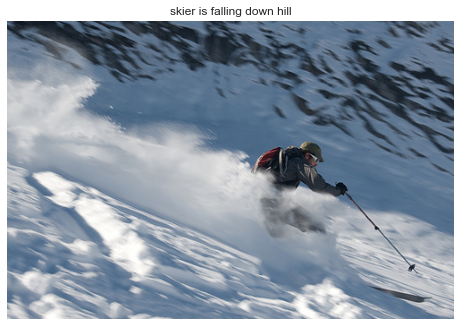

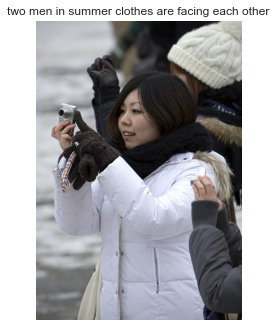

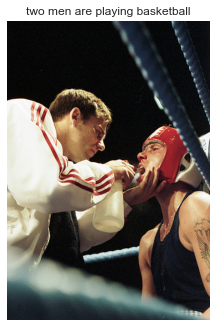

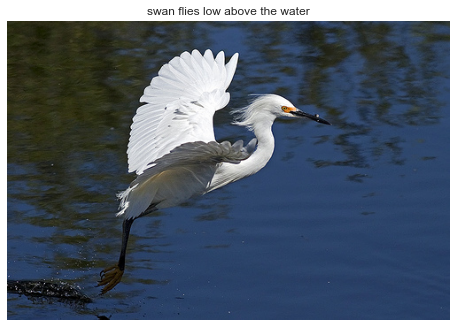

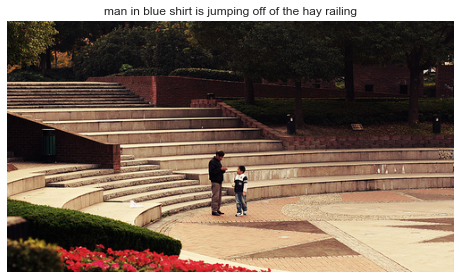

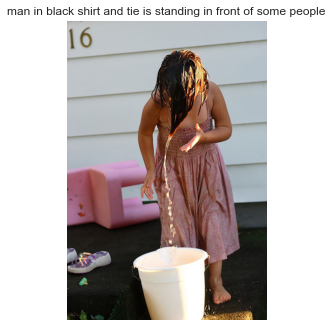

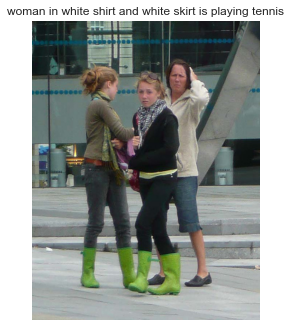

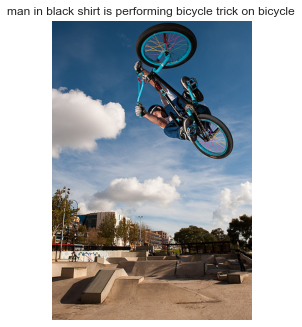

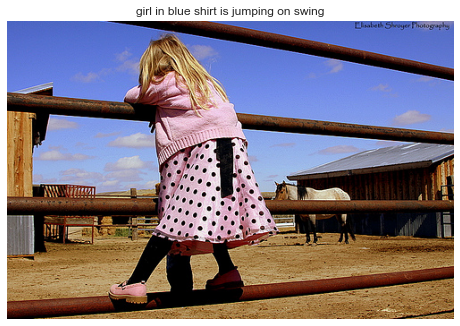

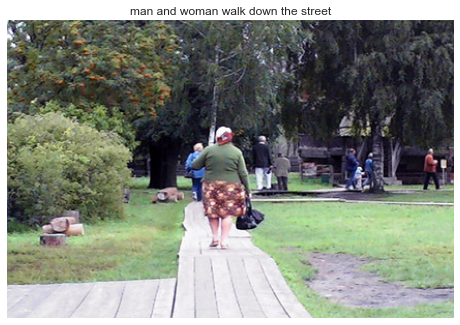

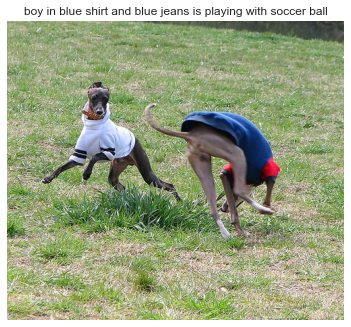

In [90]:
# pick some rnadom iamges and see result
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [ ]:
# pick some rnadom iamges and see result
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()